In [1]:
import tensorflow as tf
from tensorflow import keras
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [25]:
import numpy as np
data = np.load('combine_oneTimeStepPerSample_79_4classes_conv.npy', encoding='bytes')
data.shape

(79, 1, 150, 200, 80)

In [26]:
label = np.load('combineLabel_oneTimeStepPerSample_79_4classes_conv.npy', encoding='bytes')
label.shape

(79, 1, 150, 200, 1)

In [27]:
nValid = 4
nTest = 4
nTrain = len(data) - nValid - nTest

X_train, y_train = data[:nTrain], label[:nTrain]
X_valid, y_valid = data[nTrain:nTrain + nValid], label[nTrain:nTrain + nValid]
X_test, y_test = data[nTrain + nValid:nTrain + nValid + nTest], label[nTrain + nValid:nTrain + nValid + nTest]

In [30]:
X_train.shape, y_train.shape

((71, 1, 150, 200, 80), (71, 1, 150, 200, 1))

In [31]:
X_valid.shape, y_valid.shape

((4, 1, 150, 200, 80), (4, 1, 150, 200, 1))

In [32]:
X_test.shape, y_test.shape

((4, 1, 150, 200, 80), (4, 1, 150, 200, 1))

In [33]:
np.unique(y_train, return_counts=True), np.unique(y_valid, return_counts=True), np.unique(y_test, return_counts=True)

((array([0., 1., 2., 3.]), array([854520, 305278, 419141, 551061])),
 (array([0., 1., 2., 3.]), array([61516, 22313, 13856, 22315])),
 (array([0., 1., 2., 3.]), array([65455, 21075, 12533, 20937])))

In [34]:
sample, color,  rows ,cols, depths = X_train.shape

In [56]:
from tensorflow.keras import regularizers
input_shape = (color, rows, cols, depths)
model_conv = keras.models.Sequential([
    
    tf.keras.layers.Conv3D(
    filters = 30,
    kernel_size = (3,3,3),
    strides=(1, 1, 1),
    input_shape = input_shape,
    padding="same",
    data_format='channels_last',
    activation=tf.keras.layers.LeakyReLU(alpha=0.3),
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    
    tf.keras.layers.BatchNormalization(axis= [-3,-2]),
    
    tf.keras.layers.Conv3D(
    filters = 30,
    kernel_size = (3,3,3),
    strides=(1, 1, 1),
    padding="same",
    activation=tf.keras.layers.LeakyReLU(alpha=0.3),
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    
    tf.keras.layers.BatchNormalization(axis= [-3,-2]),
    
    tf.keras.layers.Conv3D(
    filters = 30,
    kernel_size = (3,3,3),
    strides=(1, 1, 1),
    padding="same",
    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    
    tf.keras.layers.BatchNormalization(axis= [-3,-2]),

    tf.keras.layers.Conv3D(
    filters = 30,
    kernel_size = (3,3,3),
    strides=(1, 1, 1),
    padding="same",
    activation=tf.keras.layers.LeakyReLU(alpha=0.1),
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    
    tf.keras.layers.BatchNormalization(axis= [-3,-2]),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = keras.optimizers.Adam(learning_rate= lr_schedule)
model_conv.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = optimizer,
              #loss_weights = lossWeights,
              metrics = tf.keras.metrics.SparseCategoricalAccuracy())

In [48]:
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 1, 150, 200, 30)   64830     
                                                                 
 batch_normalization_6 (Batc  (None, 1, 150, 200, 30)  120000    
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 1, 150, 200, 30)   24330     
                                                                 
 batch_normalization_7 (Batc  (None, 1, 150, 200, 30)  120000    
 hNormalization)                                                 
                                                                 
 conv3d_8 (Conv3D)           (None, 1, 150, 200, 30)   24330     
                                                                 
 batch_normalization_8 (Batc  (None, 1, 150, 200, 30) 

In [57]:
import os
checkpoint_path = "reports/conv3d_150_200_79_z and kdp_4classes.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, monitor ='val_loss',save_best_only = True)
history = model_conv.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])

Epoch 1/100
3/3 [==============================] - 3s 640ms/step - loss: 3.2434 - sparse_categorical_accuracy: 0.2389 - val_loss: 49.4884 - val_sparse_categorical_accuracy: 0.5126
Epoch 2/100
3/3 [==============================] - 1s 295ms/step - loss: 3.4978 - sparse_categorical_accuracy: 0.4012 - val_loss: 56.1082 - val_sparse_categorical_accuracy: 0.5102
Epoch 3/100
3/3 [==============================] - 1s 338ms/step - loss: 2.4561 - sparse_categorical_accuracy: 0.2855 - val_loss: 41.3895 - val_sparse_categorical_accuracy: 0.5102
Epoch 4/100
3/3 [==============================] - 1s 291ms/step - loss: 2.4749 - sparse_categorical_accuracy: 0.4029 - val_loss: 49.1809 - val_sparse_categorical_accuracy: 0.5126
Epoch 5/100
3/3 [==============================] - 1s 289ms/step - loss: 2.5890 - sparse_categorical_accuracy: 0.4665 - val_loss: 43.4918 - val_sparse_categorical_accuracy: 0.5126
Epoch 6/100
3/3 [==============================] - 1s 329ms/step - loss: 2.5807 - sparse_categorical

In [58]:
y_pred[0].shape

(1, 150, 200, 5)

In [62]:
y_pred = model_conv.predict(X_test)
y_pred_class = np.argmax(y_pred[3], axis = -1)
y_pred_class_plot = y_pred_class.reshape(150,200)
np.unique(y_pred_class, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3]), array([ 1123,  1725,  4609, 22543])),
 (array([0., 1., 2., 3.]), array([65455, 21075, 12533, 20937])))

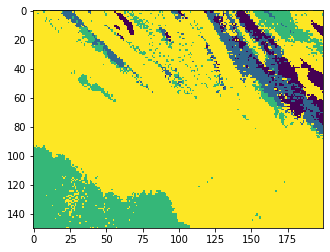

In [63]:
import matplotlib.pyplot as plt
plt.imshow(y_pred_class_plot, interpolation='none')
plt.show()

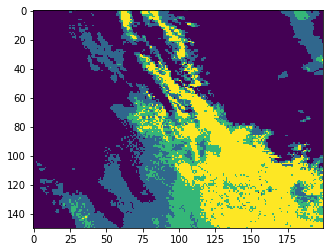

In [64]:
Y_test_plot = y_test[1].reshape(150,200)
plt.imshow(Y_test_plot, interpolation='none')
plt.show()